In [84]:
import torch
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from models.content_encoder import ContentEncoder
from models.decoder import Decoder

from hidt.networks.generators.gen_parts.content_encoders import ContentEncoderUnet
from hidt.networks.generators.gen_parts.decoders import DecoderUnet

plt.rcParams['figure.figsize'] = 8, 6

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tf.__version__

'2.2.0'

In [4]:
torch.__version__

'1.6.0'

### Content Encoder

In [85]:
model = ContentEncoder()

In [86]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
tf_op_layer_MirrorPad_59 (Tenso [(None, 1032, 1032,  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 1024, 1024, 4 11712       tf_op_layer_MirrorPad_59[0][0]   
__________________________________________________________________________________________________
instance_norm_44 (InstanceNorm) (None, 1024, 1024, 4 0           conv2d_59[0][0]                  
____________________________________________________________________________________________

In [87]:
kernels = [var for var in model.trainable_variables if 'kernel' in var.name]
biases = [var for var in model.trainable_variables if 'bias' in var.name]

for kernel, bias in zip(kernels, biases):
    print("Name: {}, kernel shape: {}, bias shape: {}".format(kernel.name, kernel.shape, bias.shape))

Name: conv2d_59/kernel:0, kernel shape: (9, 9, 3, 48), bias shape: (48,)
Name: conv2d_60/kernel:0, kernel shape: (6, 6, 48, 96), bias shape: (96,)
Name: conv2d_61/kernel:0, kernel shape: (6, 6, 96, 192), bias shape: (192,)
Name: conv2d_62/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_63/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_64/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_65/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_66/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_67/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_68/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_69/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)


In [88]:
# Loading state dict which contains weights for content_encoder, style_encoder and style generator
checkpoint_path = '/home/ivan/Documents/ml/HiDT-master/trained_models/generator/daytime.pt'
state_dict = torch.load(checkpoint_path, map_location='cpu')

In [89]:
content_encoder_dict = {key.replace('module.content_encoder.', ''): value 
                      for key, value in state_dict.items() if 'content_encoder' in key}
content_encoder_dict.keys()

dict_keys(['model_preparation.0.conv.weight', 'model_preparation.0.conv.bias', 'model_downsample.0.conv.weight', 'model_downsample.0.conv.bias', 'model_downsample.1.conv.weight', 'model_downsample.1.conv.bias', 'model_postprocess.0.model.0.model.0.conv.weight', 'model_postprocess.0.model.0.model.0.conv.bias', 'model_postprocess.0.model.0.model.1.conv.weight', 'model_postprocess.0.model.0.model.1.conv.bias', 'model_postprocess.0.model.1.model.0.conv.weight', 'model_postprocess.0.model.1.model.0.conv.bias', 'model_postprocess.0.model.1.model.1.conv.weight', 'model_postprocess.0.model.1.model.1.conv.bias', 'model_postprocess.0.model.2.model.0.conv.weight', 'model_postprocess.0.model.2.model.0.conv.bias', 'model_postprocess.0.model.2.model.1.conv.weight', 'model_postprocess.0.model.2.model.1.conv.bias', 'model_postprocess.0.model.3.model.0.conv.weight', 'model_postprocess.0.model.3.model.0.conv.bias', 'model_postprocess.0.model.3.model.1.conv.weight', 'model_postprocess.0.model.3.model.1.c

In [90]:
content_config = {
    'num_downsamples': 2,
    'num_blocks': 4,
    'input_dim': 3,
    'dim': 48,
    'norm': 'in',
    'activ': 'relu',
    'pad_type': 'reflect',
    'skip_dim': 5
}
    
content_encoder = ContentEncoderUnet(**content_config)
content_encoder.load_state_dict(content_encoder_dict)

<All keys matched successfully>

In [91]:
for submodule in content_encoder._modules['model_preparation']:    
    for key, value in submodule._modules.items():
        if key == 'conv':
            print(value.weight.size())
            print(value.bias.size())

torch.Size([48, 3, 9, 9])
torch.Size([48])


In [92]:
def get_weights_rec(module, kernels, biases):
    for key, value in module._modules.items():
        if key == 'conv':
            kernels.append(value.weight.detach().numpy())
            biases.append(value.bias.detach().numpy())
        else:
            get_weights_rec(value, kernels, biases)
            
def get_weights(model):
    kernels = []
    biases = []
    
    get_weights_rec(model, kernels, biases)
    
    return kernels, biases

In [93]:
kernels_torch, biases_torch = get_weights(content_encoder)

for kernel, bias in zip(kernels_torch, biases_torch):
    print("Kernel shape: {}, bias shape: {}".format(kernel.shape, bias.shape))

Kernel shape: (48, 3, 9, 9), bias shape: (48,)
Kernel shape: (96, 48, 6, 6), bias shape: (96,)
Kernel shape: (192, 96, 6, 6), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)


Name: conv2d/kernel:0, kernel shape: (9, 9, 3, 48), bias shape: (48,)
Name: conv2d_1/kernel:0, kernel shape: (6, 6, 48, 96), bias shape: (96,)
Name: conv2d_2/kernel:0, kernel shape: (6, 6, 96, 192), bias shape: (192,)
Name: conv2d_3/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_4/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_5/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_6/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_7/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_8/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_9/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)
Name: conv2d_10/kernel:0, kernel shape: (3, 3, 192, 192), bias shape: (192,)

In [94]:
kernel_it = kernels_torch.__iter__()
bias_it = biases_torch.__iter__()

In [95]:
for i in range(len(model.trainable_variables)):
    name = model.trainable_variables[i].name
    
    if 'kernel' in name:
        model.trainable_variables[i].assign(np.transpose(next(kernel_it), [2, 3, 1, 0]))
    elif 'bias' in name:
        model.trainable_variables[i].assign(next(bias_it))

In [96]:
input_torch = np.random.randn(1, 3, 256, 256)
input_tf = np.transpose(input_torch, [0, 2, 3, 1])

In [97]:
input_torch

array([[[[ 1.72921292,  1.04134003,  0.51415799, ...,  0.30556676,
          -0.21862244,  2.35675555],
         [-0.46478133,  0.03097519,  1.0281742 , ..., -0.86085316,
          -0.03569736, -1.32921494],
         [ 1.39001277, -0.34390666, -0.2794534 , ...,  1.36687792,
           1.4105035 , -0.36349317],
         ...,
         [ 0.74427173,  0.81304259,  0.16783238, ...,  1.00333124,
          -1.8429481 ,  0.10685466],
         [ 0.07287021, -0.86611929, -1.05535659, ..., -1.59362823,
           0.31649022, -0.73174375],
         [ 0.18615558, -1.94165869,  0.35886096, ...,  0.87085005,
           0.86271079,  0.64830923]],

        [[ 0.07814244,  0.37138454,  0.07261163, ...,  0.3380875 ,
           1.14920744, -1.52665073],
         [-0.60979475,  0.53624486,  1.33496198, ...,  0.85271846,
           0.86350986, -0.51060643],
         [ 0.3667608 ,  0.12219292, -0.15441661, ..., -0.74728641,
           0.38180475, -0.48474255],
         ...,
         [ 0.09653164,  0.49901206

In [98]:
input_tf

array([[[[ 1.72921292,  0.07814244,  1.18591889],
         [ 1.04134003,  0.37138454,  0.62619574],
         [ 0.51415799,  0.07261163,  1.39089955],
         ...,
         [ 0.30556676,  0.3380875 , -1.18144377],
         [-0.21862244,  1.14920744, -0.56290274],
         [ 2.35675555, -1.52665073, -0.82598659]],

        [[-0.46478133, -0.60979475,  0.79008862],
         [ 0.03097519,  0.53624486,  1.07839161],
         [ 1.0281742 ,  1.33496198, -0.50121266],
         ...,
         [-0.86085316,  0.85271846,  0.5196797 ],
         [-0.03569736,  0.86350986, -1.2611427 ],
         [-1.32921494, -0.51060643, -0.290377  ]],

        [[ 1.39001277,  0.3667608 , -0.82424561],
         [-0.34390666,  0.12219292,  0.42388344],
         [-0.2794534 , -0.15441661,  0.70517195],
         ...,
         [ 1.36687792, -0.74728641,  0.01122044],
         [ 1.4105035 ,  0.38180475, -0.71911721],
         [-0.36349317, -0.48474255, -1.9391025 ]],

        ...,

        [[ 0.74427173,  0.09653164, -1

In [99]:
torch_out = content_encoder(torch.Tensor(input_torch))
tf_out = model(input_tf)

In [100]:
torch_out_np = [out.detach().numpy() for out in torch_out]
for out in torch_out_np:
    print(out.shape)

(1, 192, 64, 64)
(1, 5, 128, 128)
(1, 5, 256, 256)


In [101]:
tf_out_np = []
tf_out_np.append(tf_out[0].numpy().transpose([0, 3, 1, 2]))
tf_out_np.append(tf_out[1][0].numpy().transpose([0, 3, 1, 2]))
tf_out_np.append(tf_out[1][1].numpy().transpose([0, 3, 1, 2]))

for out in tf_out_np:
    print(out.shape)

# tf_out_np = tf_out.numpy().transpose([0, 3, 1, 2])
#for out in tf_out_np:
# print(tf_out_np.shape)

(1, 192, 64, 64)
(1, 5, 128, 128)
(1, 5, 256, 256)


In [102]:
tf_out[0]

<tf.Tensor: shape=(1, 64, 64, 192), dtype=float32, numpy=
array([[[[ 1.3438318 ,  1.498033  ,  1.1272511 , ...,  0.2659616 ,
           1.1859908 ,  0.6026212 ],
         [ 0.6536654 , -0.04463911,  0.5925734 , ...,  0.5512185 ,
           0.7879213 ,  0.8785232 ],
         [ 0.22968557,  0.4950432 , -0.26436853, ...,  0.24117336,
           0.19518209,  1.1617229 ],
         ...,
         [ 0.7022667 ,  0.4795413 ,  0.59837085, ...,  0.5170663 ,
           0.7280102 ,  0.03196472],
         [ 0.18254828,  1.1179149 ,  0.543036  , ...,  0.37415308,
           0.41256195, -0.14553213],
         [ 0.4245832 ,  0.59259856,  0.23219383, ...,  0.3845206 ,
           0.3352493 , -0.41777682]],

        [[ 0.60312355,  0.6032108 ,  0.00680888, ...,  0.12272227,
           0.94317824, -0.12915617],
         [-0.5298469 ,  0.56334174,  0.25721788, ...,  0.36799487,
           0.15313661,  0.33646184],
         [ 0.3287733 , -0.19923544, -0.11953598, ...,  0.428945  ,
           0.47386622,  0.2

In [103]:
for torch_out_, tf_out_ in zip(torch_out_np, tf_out_np):
    diff = np.mean(np.abs(torch_out_ - tf_out_))
    
    print("Diff: {}".format(diff))

Diff: 0.0002088941546389833
Diff: 7.000696496106684e-05
Diff: 6.973365816520527e-05


In [24]:
tf.saved_model.save(model, "./ce1024_withoutnorm") 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./ce1024_withoutnorm/assets


In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model('./ce1024_withoutnorm')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("ce1024_withoutnorm_float.tflite", "wb").write(tflite_model)

7013008

#### Inference time (PyTorch model, TF model and compiled TF model)

In [54]:
%%timeit
torch_out = content_encoder(torch.Tensor(input_torch))

365 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%%timeit
tf_out = model(input_tf)

396 ms ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
@tf.function
def infer_model(input_):
    out = model(input_)
    
    return out

In [57]:
%%timeit
tf_out = infer_model(input_tf)

385 ms ± 60.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
# Save content encoder model
tf.keras.models.save_model(model, 'tf_models/content_encoder_noskip')

INFO:tensorflow:Assets written to: tf_models/content_encoder_noskip/assets


INFO:tensorflow:Assets written to: tf_models/content_encoder_noskip/assets


In [61]:
converter = tf.lite.TFLiteConverter.from_saved_model('tf_models/content_encoder_noskip')
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

3550080

In [48]:
import torch
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from pytorch2tf.models.content_encoder import ContentEncoder
from pytorch2tf.models.decoder import Decoder

from hidt.networks.generators.gen_parts.content_encoders import ContentEncoderUnet
from hidt.networks.generators.gen_parts.decoders import DecoderUnet

plt.rcParams['figure.figsize'] = 8, 6

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Decoder

In [204]:
decoder_dict = {key.replace('module.decoder.', ''): value 
                      for key, value in state_dict.items() if 'decoder' in key}
decoder_dict.keys()

dict_keys(['body.0.model.0.model.0.norm.running_mean', 'body.0.model.0.model.0.norm.running_var', 'body.0.model.0.model.0.conv.weight', 'body.0.model.0.model.0.conv.bias', 'body.0.model.0.model.1.norm.running_mean', 'body.0.model.0.model.1.norm.running_var', 'body.0.model.0.model.1.conv.weight', 'body.0.model.0.model.1.conv.bias', 'body.0.model.1.model.0.norm.running_mean', 'body.0.model.1.model.0.norm.running_var', 'body.0.model.1.model.0.conv.weight', 'body.0.model.1.model.0.conv.bias', 'body.0.model.1.model.1.norm.running_mean', 'body.0.model.1.model.1.norm.running_var', 'body.0.model.1.model.1.conv.weight', 'body.0.model.1.model.1.conv.bias', 'body.0.model.2.model.0.norm.running_mean', 'body.0.model.2.model.0.norm.running_var', 'body.0.model.2.model.0.conv.weight', 'body.0.model.2.model.0.conv.bias', 'body.0.model.2.model.1.norm.running_mean', 'body.0.model.2.model.1.norm.running_var', 'body.0.model.2.model.1.conv.weight', 'body.0.model.2.model.1.conv.bias', 'body.0.model.3.model.0

In [205]:
decoder_dict['adain_net.model.2.fc.weight'].size()

torch.Size([3860, 64])

In [206]:
decoder_config = {
    'res_norm': 'adain',
    'up_norm': 'ln',
    'num_upsamples': 2,
    'num_blocks': 5,
    'dim': 192,
    'activ': 'relu',
    'pad_type': 'reflect',
    'num_res_conv': 0,
    'skip_dim': 5,
    'output_dim': 6, # Output image + segmentation
    'adain_net': {
        'architecture': 'MLP',
        'input_dim': 3,
        'dim': 64,
        'num_blocks': 3,
        'norm': 'none',
        'activ': 'relu'
    }
}
    
decoder = DecoderUnet(**decoder_config)
decoder.load_state_dict(decoder_dict)
decoder.eval()

DecoderUnet(
  (body): ModuleList(
    (0): ResBlocks(
      (model): Sequential(
        (0): ResBlock(
          (model): ModuleList(
            (0): Conv2dBlock(
              (pad): ReflectionPad2d((1, 1, 1, 1))
              (norm): AdaptiveInstanceNorm2d(192)
              (activation): ReLU(inplace=True)
              (conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
            )
            (1): Conv2dBlock(
              (pad): ReflectionPad2d((1, 1, 1, 1))
              (norm): AdaptiveInstanceNorm2d(192)
              (conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
            )
          )
        )
        (1): ResBlock(
          (model): ModuleList(
            (0): Conv2dBlock(
              (pad): ReflectionPad2d((1, 1, 1, 1))
              (norm): AdaptiveInstanceNorm2d(192)
              (activation): ReLU(inplace=True)
              (conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
            )
            (1): Conv2dBlock(
       

In [207]:
model_decoder = Decoder()

(None, 128, 128, 192) (None, 128, 128, 5)
(None, 128, 128, 197)
(None, 256, 256, 96) (None, 256, 256, 5)
(None, 256, 256, 101)
(None, 256, 256, 6)


In [208]:
model_decoder.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           256         input_18[0][0]                   
__________________________________________________________________________________________________
re_lu_64 (ReLU)                 (None, 64)           0           dense_6[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           4160        re_lu_64[0][0]                   
____________________________________________________________________________________________

In [209]:
def get_weights_rec(module, kernels, biases):
    for key, value in module._modules.items():
        if key == 'conv' or key == "fc":
            kernels.append(value.weight.detach().numpy())
            biases.append(value.bias.detach().numpy())
        else:
            get_weights_rec(value, kernels, biases)
            
def get_weights(model):
    kernels = []
    biases = []
    
    get_weights_rec(model._modules["adain_net"], kernels, biases)
    get_weights_rec(model._modules["body"], kernels, biases)
    for i in range(len(model._modules["upsample_head"])):
        get_weights_rec(model._modules["upsample_head"][i], kernels, biases)
        get_weights_rec(model._modules["skip_preprocess"][i], kernels, biases)
        get_weights_rec(model._modules["upsample_postprocess"][i], kernels, biases)
    get_weights_rec(model._modules["model_postprocess"], kernels, biases)
    
    return kernels, biases

In [210]:
kernels_torch, biases_torch = get_weights(decoder)

for kernel, bias in zip(kernels_torch, biases_torch):
    print("Kernel shape: {}, bias shape: {}".format(kernel.shape, bias.shape))

Kernel shape: (64, 3), bias shape: (64,)
Kernel shape: (64, 64), bias shape: (64,)
Kernel shape: (3860, 64), bias shape: (3860,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (192, 192, 3, 3), bias shape: (192,)
Kernel shape: (5, 5, 7, 7), bias shape: (5,)
Kernel shape: (96, 197, 7, 7), bias shape: (96,)
Kernel shape: (5, 5, 7, 7), bias shape: (5,)
Kernel shape: (48, 101, 7, 7), bias shape: (48,)
Kernel shape: (6, 48, 9, 9), bias shape: (6,)


In [211]:
for i in model_decoder.trainable_variables:
    print(i.name, ": ", i.shape)

dense_6/kernel:0 :  (3, 64)
dense_6/bias:0 :  (64,)
dense_7/kernel:0 :  (64, 64)
dense_7/bias:0 :  (64,)
dense_8/kernel:0 :  (64, 3860)
dense_8/bias:0 :  (3860,)
conv2d_96/kernel:0 :  (3, 3, 192, 192)
conv2d_96/bias:0 :  (192,)
conv2d_97/kernel:0 :  (3, 3, 192, 192)
conv2d_97/bias:0 :  (192,)
conv2d_98/kernel:0 :  (3, 3, 192, 192)
conv2d_98/bias:0 :  (192,)
conv2d_99/kernel:0 :  (3, 3, 192, 192)
conv2d_99/bias:0 :  (192,)
conv2d_100/kernel:0 :  (3, 3, 192, 192)
conv2d_100/bias:0 :  (192,)
conv2d_101/kernel:0 :  (3, 3, 192, 192)
conv2d_101/bias:0 :  (192,)
conv2d_102/kernel:0 :  (3, 3, 192, 192)
conv2d_102/bias:0 :  (192,)
conv2d_103/kernel:0 :  (3, 3, 192, 192)
conv2d_103/bias:0 :  (192,)
conv2d_104/kernel:0 :  (3, 3, 192, 192)
conv2d_104/bias:0 :  (192,)
conv2d_105/kernel:0 :  (3, 3, 192, 192)
conv2d_105/bias:0 :  (192,)
conv2d_106/kernel:0 :  (7, 7, 5, 5)
conv2d_106/bias:0 :  (5,)
conv2d_107/kernel:0 :  (7, 7, 197, 96)
conv2d_107/bias:0 :  (96,)
conv2d_108/kernel:0 :  (7, 7, 5, 5)
co

In [212]:
kernel_it = kernels_torch.__iter__()
bias_it = biases_torch.__iter__()

In [213]:
for i in range(len(model_decoder.trainable_variables)):
    name = model_decoder.trainable_variables[i].name
    
    if 'kernel' in name:
        if 'dense' in name:
            model_decoder.trainable_variables[i].assign(np.transpose(next(kernel_it), [1, 0]))
        elif 'conv' in name:
            model_decoder.trainable_variables[i].assign(np.transpose(next(kernel_it), [2, 3, 1, 0]))
    elif 'bias' in name:
        model_decoder.trainable_variables[i].assign(next(bias_it))

In [214]:
kernels_torch

[array([[ 2.9854542e-01,  1.6441909e+00,  7.3940970e-02],
        [-7.5702697e-01,  5.1474714e-01,  2.9523847e-01],
        [-5.0132871e-01, -2.1891099e-01, -2.3979445e-01],
        [-5.3824240e-01, -2.0313326e-01,  1.6433171e+00],
        [-3.5927412e-01,  8.1709445e-01,  6.8162546e-02],
        [-1.2799445e+00,  1.9027826e-01,  2.4972300e-01],
        [-9.4727226e-02,  4.5564145e-02, -1.9250892e+00],
        [-5.3539121e-01, -4.2012838e-01,  3.6117122e-01],
        [ 9.0431279e-01, -1.5494802e-02, -1.2881262e+00],
        [-1.2262894e-01,  6.3712090e-01, -5.3855265e-04],
        [ 1.5717092e-01,  8.0491972e-01, -3.4572062e-01],
        [-1.1363716e+00, -3.5330898e-01,  2.8028011e-01],
        [-4.0205404e-01, -6.6442698e-01, -1.1215082e+00],
        [ 5.4107344e-01, -5.2272223e-02,  1.7789120e-02],
        [-2.9744220e-01,  7.4838512e-02, -1.3865516e-01],
        [ 7.1350318e-01, -2.2195759e-01,  2.9893258e-01],
        [ 4.0802404e-01, -9.6908492e-01, -1.3696854e-01],
        [ 9.70

In [215]:
model_decoder.trainable_variables

[<tf.Variable 'dense_6/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[ 2.9854542e-01, -7.5702697e-01, -5.0132871e-01, -5.3824240e-01,
         -3.5927412e-01, -1.2799445e+00, -9.4727226e-02, -5.3539121e-01,
          9.0431279e-01, -1.2262894e-01,  1.5717092e-01, -1.1363716e+00,
         -4.0205404e-01,  5.4107344e-01, -2.9744220e-01,  7.1350318e-01,
          4.0802404e-01,  9.7033954e-01, -2.7112433e-01,  1.0456443e-02,
         -1.0130919e+00, -7.6343966e-01, -4.8511899e-01,  7.4636802e-02,
         -2.4452786e-01,  1.5475877e-01, -5.4200327e-01, -4.7003537e-01,
          1.8991892e-01,  7.9090595e-01,  3.7165788e-01,  3.2311359e-01,
         -8.3936083e-01,  8.6573708e-01, -5.0243121e-01, -7.6756620e-01,
          4.6301576e-01,  1.1209704e+00,  7.4218385e-02,  6.8523204e-01,
          7.9417711e-01,  5.6572974e-01, -3.5326788e-01,  1.1323403e+00,
          5.9587061e-02,  4.6123111e-01, -1.4266326e+00,  4.9680728e-02,
          4.0044788e-02, -3.3138645e-01, -9.6354373e-02

In [216]:
input_torch = np.random.randn(1, 192, 64, 64)
skip2_torch = np.random.randn(1, 5, 128, 128)
skip1_torch = np.random.randn(1, 5, 256, 256)
style_torch = np.random.randn(1, 3)


input_tf = np.transpose(input_torch, [0, 2, 3, 1])
skip2_tf = np.transpose(skip2_torch, [0, 2, 3, 1])
skip1_tf = np.transpose(skip1_torch, [0, 2, 3, 1])
style_tf = style_torch

In [217]:
torch_out = decoder([torch.Tensor(input_torch), torch.Tensor(skip2_torch), torch.Tensor(skip1_torch)], torch.Tensor(style_torch))
tf_out = model_decoder([input_tf, skip2_tf, skip1_tf, style_tf])

In [218]:
torch_out_np = torch_out.detach().numpy()
print(torch_out_np.shape)

(1, 6, 256, 256)


In [219]:
torch_out_np

array([[[[-2.22905779e+00, -2.14532638e+00, -1.69015884e+00, ...,
           3.12922335e+00,  4.03918028e+00,  4.10737610e+00],
         [-2.17859650e+00, -1.84181774e+00, -1.76406217e+00, ...,
           4.44178200e+00,  4.86379623e+00,  5.13646364e+00],
         [-2.24375558e+00, -2.15129471e+00, -1.66026127e+00, ...,
           3.30598903e+00,  3.21112251e+00,  3.69087672e+00],
         ...,
         [ 2.04642725e+00,  1.95902658e+00,  1.97228587e+00, ...,
           4.53396976e-01,  3.98587376e-01,  4.08878177e-01],
         [ 2.58427262e+00,  2.34761071e+00,  2.36476016e+00, ...,
           4.75184351e-01,  4.60420609e-01,  4.28132892e-01],
         [ 2.24462533e+00,  2.23245144e+00,  2.25665426e+00, ...,
           4.90874708e-01,  4.83044654e-01,  4.25527632e-01]],

        [[-1.89148593e+00, -1.88095129e+00, -1.77131855e+00, ...,
           2.47942138e+00,  2.66562152e+00,  2.80389380e+00],
         [-1.89719462e+00, -1.85709012e+00, -1.95325601e+00, ...,
           3.56845975e

In [220]:
tf_out_np = np.transpose(tf_out.numpy(), [0, 3, 1, 2])
print(tf_out_np.shape)

(1, 6, 256, 256)


In [221]:
tf_out_np

array([[[[-1.34053478e+01, -1.33055544e+01, -1.28998213e+01, ...,
           9.74763870e+00,  9.84742069e+00,  9.73560524e+00],
         [-1.34330702e+01, -1.32336473e+01, -1.29354925e+01, ...,
           9.78457069e+00,  9.77527237e+00,  9.66585350e+00],
         [-1.34292526e+01, -1.33207264e+01, -1.29083881e+01, ...,
           9.48525047e+00,  9.34784031e+00,  9.35024071e+00],
         ...,
         [ 6.53993797e+00,  6.54244947e+00,  6.48529243e+00, ...,
          -7.58047044e-01, -5.40522277e-01, -4.81085747e-01],
         [ 6.86489058e+00,  6.83462381e+00,  6.76403379e+00, ...,
          -3.14892530e-01, -1.08795844e-01, -5.93189560e-02],
         [ 6.92585897e+00,  6.90681982e+00,  6.93598366e+00, ...,
          -1.51371226e-01,  4.65263277e-02,  8.64092037e-02]],

        [[-1.11001015e+01, -1.10836668e+01, -1.08889856e+01, ...,
           6.48213291e+00,  6.56483126e+00,  6.58275652e+00],
         [-1.11267958e+01, -1.10891018e+01, -1.09616432e+01, ...,
           6.46104956e

In [222]:
print(torch_out_np[:, :3, ::].min())
print(torch_out_np[:, :3, ::].max())
print(tf_out_np[:, :3, ::].min())
print(tf_out_np[:, :3, ::].max())

-4.665506
20.749567
-15.597551
19.597492


In [223]:
diff = np.mean(np.abs(torch_out_np[:, 3:, ::] - tf_out_np[:, 3:, ::]))
print("Diff: {}".format(diff))

Diff: 1.2165080308914185


In [235]:
# Save content encoder model
tf.keras.models.save_model(model_decoder, 'tf_models/decoder')

INFO:tensorflow:Assets written to: tf_models/decoder/assets


INFO:tensorflow:Assets written to: tf_models/decoder/assets


In [236]:
converter = tf.lite.TFLiteConverter.from_saved_model('tf_models/decoder')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
#                                        tf.lite.OpsSet.SELECT_TF_OPS]
# converter.allow_custom_ops = True
tflite_model = converter.convert()
open("decoder_model_q.tflite", "wb").write(tflite_model)

ConverterError: See console for info.
2020-08-31 18:41:54.987565: W tensorflow/compiler/mlir/lite/python/graphdef_to_tfl_flatbuffer.cc:144] Ignored output_format.
2020-08-31 18:41:54.987622: W tensorflow/compiler/mlir/lite/python/graphdef_to_tfl_flatbuffer.cc:147] Ignored drop_control_dependency.
2020-08-31 18:41:55.125076: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-08-31 18:41:55.158325: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1800000000 Hz
2020-08-31 18:41:55.158775: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8a4c000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-08-31 18:41:55.158803: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-08-31 18:41:55.162184: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-08-31 18:41:55.162400: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-08-31 18:41:55.162426: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivan-Lenovo-ideapad-720-15IKB): /proc/driver/nvidia/version does not exist
loc(fused["model_8/up_sampling2d_15/resize/ResizeNearestNeighbor@__inference__wrapped_model_66751", "StatefulPartitionedCall/model_8/up_sampling2d_15/resize/ResizeNearestNeighbor"]): error: 'tf.ResizeNearestNeighbor' op is neither a custom op nor a flex op
loc(fused["model_8/up_sampling2d_16/resize/ResizeNearestNeighbor@__inference__wrapped_model_66751", "StatefulPartitionedCall/model_8/up_sampling2d_16/resize/ResizeNearestNeighbor"]): error: 'tf.ResizeNearestNeighbor' op is neither a custom op nor a flex op
error: failed while converting: 'main': Ops that can be supported by the flex runtime (enabled via setting the -emit-select-tf-ops flag): ResizeNearestNeighbor,ResizeNearestNeighbor.
Traceback (most recent call last):
  File "/home/ivan/anaconda3/envs/tf/bin/toco_from_protos", line 8, in <module>
    sys.exit(main())
  File "/home/ivan/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 93, in main
    app.run(main=execute, argv=[sys.argv[0]] + unparsed)
  File "/home/ivan/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/home/ivan/anaconda3/envs/tf/lib/python3.8/site-packages/absl/app.py", line 300, in run
    _run_main(main, args)
  File "/home/ivan/anaconda3/envs/tf/lib/python3.8/site-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/home/ivan/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 50, in execute
    output_str = _pywrap_toco_api.TocoConvert(
Exception: <unknown>:0: error: loc(fused["model_8/up_sampling2d_15/resize/ResizeNearestNeighbor@__inference__wrapped_model_66751", "StatefulPartitionedCall/model_8/up_sampling2d_15/resize/ResizeNearestNeighbor"]): 'tf.ResizeNearestNeighbor' op is neither a custom op nor a flex op
<unknown>:0: error: loc(fused["model_8/up_sampling2d_16/resize/ResizeNearestNeighbor@__inference__wrapped_model_66751", "StatefulPartitionedCall/model_8/up_sampling2d_16/resize/ResizeNearestNeighbor"]): 'tf.ResizeNearestNeighbor' op is neither a custom op nor a flex op
<unknown>:0: error: failed while converting: 'main': Ops that can be supported by the flex runtime (enabled via setting the -emit-select-tf-ops flag): ResizeNearestNeighbor,ResizeNearestNeighbor.





### TF realization launch

In [124]:
from PIL import Image

from hidt.utils.preprocessing import get_transform
from hidt.utils.preprocessing import get_params

In [125]:
# Implementation of image preprocessing taken from hidt with slight modifications
def preprocess_images(pil_image, transformer):
    """
    :param pil_image: a single PIL image or a list of PIL images
    :param mode: 'content' or 'style' (influences on the applied image transformer)
    :return: list of 4D Tensor with shape B x C x H x W
    """

    if not isinstance(pil_image, (list, tuple)):
        pil_image = [pil_image]

    output = []
    equally_sized_batch = True
    for cur_image in pil_image:
        if cur_image.size != pil_image[0].size:
            equally_sized_batch = False
        output.append(transformer(
            cur_image).to('cpu'))

    if len(output) > 1:
        if equally_sized_batch:
            return [torch.stack(output)]
        else:
            return [tensor.unsqueeze(0) for tensor in output]
    else:
        return [torch.stack(output)]

In [128]:
content_image = Image.open('./0.jpg')

In [129]:
IMAGE_WIDTH, IMAGE_HEIGHT = 1024, 1024 # Redundant for our config

transform_params = {
    'color_space': 'rgb',
    'preprocess': 'scale_load_shorter_side',
    'load_size': 256,
    'no_flip': True,
    'dequantization': True,
    'crop_image_height': 256, # This one is redundant in this type of processing                 
    'crop_image_width': 256   # This one is redundant in this type of processing 
}

content_img_transformer = get_transform(
    get_params(transform_params, size=(IMAGE_WIDTH, IMAGE_HEIGHT)))
images_proc = preprocess_images(content_image, content_img_transformer)

In [130]:
content_input_tensor = tf.convert_to_tensor(np.transpose(images_proc[0].detach().numpy(), [0, 2, 3, 1]))

In [131]:
content_input_tensor.shape

TensorShape([1, 256, 384, 3])

In [132]:
content_encoding = model(content_input_tensor)

In [133]:
print(content_encoding[0].shape)
print(content_encoding[1][0].shape)
print(content_encoding[1][1].shape)

(1, 64, 96, 192)
(1, 128, 192, 5)
(1, 256, 384, 5)


In [190]:
style_tf = tf.constant([-0.5931239, 1.0842981, -1.2714428], shape=(1, 3), dtype = tf.float32)

In [191]:
style_tf.shape

TensorShape([1, 3])

In [192]:
decoded_info = model_decoder([content_encoding[0], content_encoding[1][0], content_encoding[1][1], style_tf])

In [201]:
from tensorflow.keras.activations import tanh
def get_image(decoded_info):
    decoded_info = tanh(decoded_info).numpy()
    print(decoded_info)
    
    decoded_image = ((decoded_info[:, :, :, :3] + 1.) / 2.) * 255.
    decoded_image = np.array(decoded_image, dtype = np.int)
    return decoded_image

In [202]:
res_image = get_image(decoded_info)

[[[[ 0.99999493 -0.31709558  0.2752562  -0.10454509 -0.26571083
     0.213699  ]
   [ 0.9999947  -0.31688493  0.2956855  -0.10125005 -0.26543778
     0.21353114]
   [ 0.99999505 -0.28236696  0.33658513 -0.0923116  -0.26750347
     0.20942259]
   ...
   [ 0.99991536 -0.5153606   0.90474945 -0.16602615 -0.21708554
     0.328246  ]
   [ 0.9999166  -0.5225459   0.9030939  -0.15613285 -0.22568613
     0.32447332]
   [ 0.9999159  -0.5264708   0.90014315 -0.15249063 -0.23135184
     0.3234462 ]]

  [[ 0.9999938  -0.34718072  0.23638311 -0.11753288 -0.24703607
     0.22357015]
   [ 0.9999938  -0.3480887   0.2632124  -0.11471216 -0.24645299
     0.22305082]
   [ 0.99999416 -0.3273837   0.30656067 -0.10701802 -0.24818346
     0.21972515]
   ...
   [ 0.99991584 -0.5083563   0.90447956 -0.18165559 -0.21616502
     0.3322495 ]
   [ 0.99991715 -0.513869    0.902985   -0.1736476  -0.22392333
     0.3289138 ]
   [ 0.9999166  -0.51635736  0.9004449  -0.17059058 -0.22855848
     0.32751304]]

  [[ 0.999

In [195]:
res_image.shape


(1, 256, 384, 3)

In [196]:
res_image

array([[[[254,  87, 162],
         [254,  87, 165],
         [254,  91, 170],
         ...,
         [254,  61, 242],
         [254,  60, 242],
         [254,  60, 242]],

        [[254,  83, 157],
         [254,  83, 161],
         [254,  85, 166],
         ...,
         [254,  62, 242],
         [254,  61, 242],
         [254,  61, 242]],

        [[254,  61, 151],
         [254,  61, 154],
         [254,  63, 159],
         ...,
         [254,  62, 242],
         [254,  61, 242],
         [254,  60, 242]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
        

In [197]:
image2 = Image.fromarray(res_image[0], 'RGB')

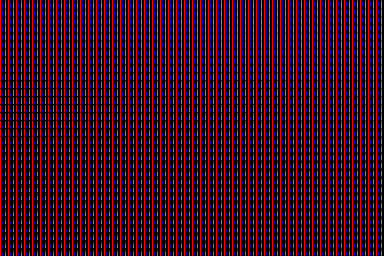

In [198]:
image2

### Pytorch example launch

In [176]:
import argparse
import glob
import os
import sys

import torch
from PIL import Image
from torchvision import transforms

from hidt.networks.enhancement.RRDBNet_arch import RRDBNet
from hidt.style_transformer import StyleTransformer
from hidt.utils.preprocessing import GridCrop, enhancement_preprocessing


In [177]:
config_path = './hidt/configs/daytime.yaml'
gen_weights_path = './hidt/trained_models/generator/daytime.pt'
inference_size = 256  # the network has been trained to do inference in 256px, any higher value might lead to artifacts
device = 'cpu:0'
image_path = './0.jpg'
styles_path = './hidt/styles.txt'

style_transformer = StyleTransformer(config_path,
                                     gen_weights_path,
                                     inference_size=inference_size,
                                     device=device)
with open(styles_path) as f:
    styles = f.read()
styles = {style.split(',')[0]: torch.tensor([float(el) for el in style.split(',')[1][1:-1].split(' ')]) for style in styles.split('\n')[:-1]}
image = Image.open(image_path)
crop_transform = GridCrop(4, 1, hires_size=inference_size * 4)

In [185]:
style_to_transfer = styles['sunset_hard_harder']

In [186]:
style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)
with torch.no_grad():
    content_decomposition = style_transformer.get_content(image)[0]
    decoder_input = {'content': content_decomposition['content'],
                     'intermediate_outputs': content_decomposition['intermediate_outputs'],
                     'style': style_to_transfer}
    transferred = style_transformer.trainer.gen.decode(decoder_input)
    print(transferred)
    transferred = transferred['images']

{'images': {'color_space': 'rgb', 'dim': 3, 'type': 'style'}, 'segmentation_maps': {'color_space': 'rgb', 'dim': 3, 'type': 'content'}}
{'images': tensor([[[[ 0.3526,  0.3354,  0.3407,  ...,  0.3332,  0.3327,  0.3279],
          [ 0.1357,  0.1460,  0.1610,  ...,  0.3313,  0.3336,  0.3255],
          [ 0.0887,  0.0899,  0.1105,  ...,  0.3329,  0.3288,  0.3217],
          ...,
          [-0.9639, -0.9635, -0.9652,  ..., -0.9739, -0.9810, -0.9838],
          [-0.9703, -0.9710, -0.9725,  ..., -0.9510, -0.9697, -0.9740],
          [-0.9686, -0.9668, -0.9689,  ..., -0.9559, -0.9501, -0.8895]],

         [[ 0.1769,  0.1617,  0.1620,  ...,  0.1907,  0.1809,  0.1808],
          [ 0.0174,  0.0052,  0.0128,  ...,  0.1881,  0.1856,  0.1795],
          [-0.0315, -0.0380, -0.0456,  ...,  0.1847,  0.1748,  0.1690],
          ...,
          [-0.9561, -0.9582, -0.9612,  ..., -0.9840, -0.9893, -0.9907],
          [-0.9658, -0.9684, -0.9735,  ..., -0.9711, -0.9822, -0.9858],
          [-0.9632, -0.9624, 

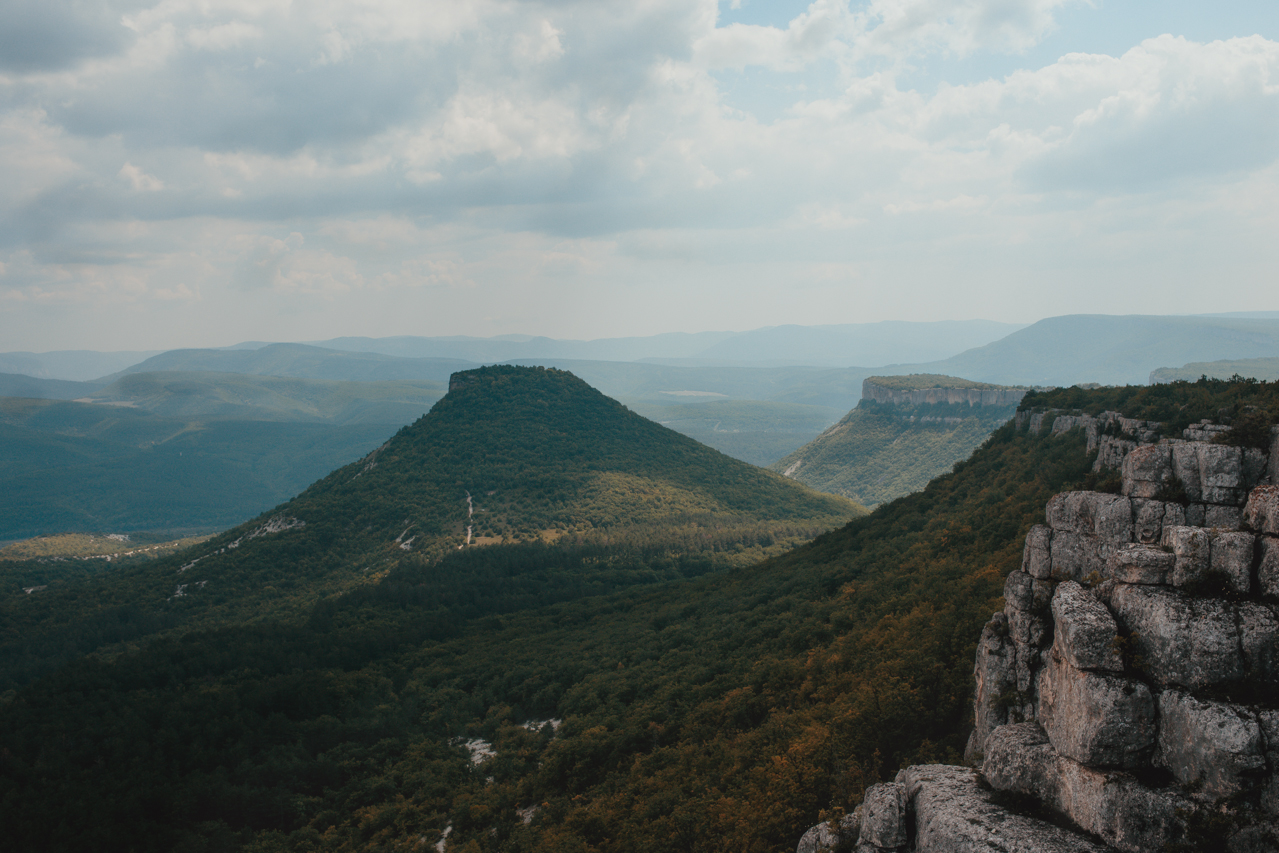

In [187]:
image

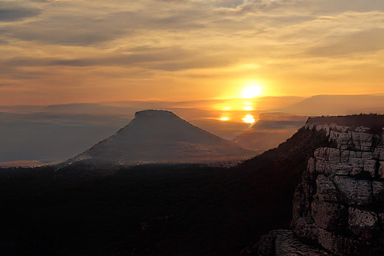

In [188]:
transforms.ToPILImage()((transferred[0].cpu().clamp(-1, 1) + 1.) / 2.)

### Some piece of shit with shapes

In [176]:
example_inputs = tf.convert_to_tensor(np.random.randn(1, 192, 64, 64), dtype=tf.float32)

In [177]:
example_inputs

<tf.Tensor: shape=(1, 192, 64, 64), dtype=float32, numpy=
array([[[[-0.6508279 ,  0.63316035, -1.1287055 , ...,  0.04729635,
           0.83705676,  1.3572292 ],
         [ 0.49627492,  0.60689926, -1.808986  , ..., -0.39514178,
           1.0149606 , -0.5764984 ],
         [ 0.38410598, -1.4303311 , -0.58587986, ...,  0.8583779 ,
           0.87164044,  0.30283502],
         ...,
         [-0.8402848 ,  0.1458408 , -0.3754616 , ..., -0.14107847,
          -1.5427862 ,  0.16878323],
         [ 0.5099757 ,  0.04883295, -1.4301723 , ...,  0.2197863 ,
          -0.02224514,  1.4589608 ],
         [ 1.443851  ,  0.6354442 , -0.10310371, ...,  0.5620531 ,
           0.49451578,  1.652461  ]],

        [[ 1.4003395 , -0.44459787, -0.31401232, ..., -1.2375238 ,
          -0.45859334, -0.07047044],
         [ 0.65967757,  1.4727523 ,  1.608022  , ...,  1.3368309 ,
           1.2394398 , -0.07850853],
         [-1.1150279 , -2.0093753 , -0.9413087 , ..., -2.098033  ,
           1.717342  , -0.1

In [79]:
from tensorflow import nn

In [187]:
mean, variance = nn.moments(
            example_inputs, -1, keepdims=True)

In [134]:
print(mean, '\n', variance)

tf.Tensor(
[[[[ 0.07499073]
   [-0.10530957]
   [ 0.15419388]
   ...
   [ 0.08348507]
   [ 0.25701293]
   [-0.01949974]]

  [[-0.19371615]
   [-0.00566462]
   [-0.03928656]
   ...
   [-0.01228059]
   [ 0.08488618]
   [-0.07056569]]

  [[ 0.1473954 ]
   [-0.23537588]
   [ 0.09339677]
   ...
   [ 0.00445417]
   [-0.15183656]
   [ 0.2791972 ]]

  ...

  [[ 0.00776241]
   [ 0.04603391]
   [-0.01126662]
   ...
   [ 0.11931134]
   [-0.00197479]
   [ 0.13728121]]

  [[-0.01071865]
   [ 0.18224163]
   [ 0.09769806]
   ...
   [ 0.06737119]
   [ 0.1301157 ]
   [ 0.17342207]]

  [[ 0.00788768]
   [ 0.00598253]
   [-0.00420488]
   ...
   [ 0.13841972]
   [-0.03681186]
   [-0.12404883]]]], shape=(1, 192, 64, 1), dtype=float32) 
 tf.Tensor(
[[[[1.2055835 ]
   [1.0575744 ]
   [0.9789771 ]
   ...
   [1.0599021 ]
   [1.0538113 ]
   [0.93715703]]

  [[1.2431225 ]
   [0.94376373]
   [0.7306026 ]
   ...
   [0.5844382 ]
   [0.896474  ]
   [0.8111392 ]]

  [[0.89348936]
   [0.65067935]
   [0.6871332 ]
   ..

In [188]:
from pytorch2tf.models.norm import LayerNorm

outputs = LayerNorm()(example_inputs)


In [189]:
from tensorflow.keras.layers import LayerNormalization
outputs2 = LayerNormalization()(example_inputs)

In [190]:
outputs

<tf.Tensor: shape=(1, 192, 64, 64), dtype=float32, numpy=
array([[[[-5.40856600e-01,  7.99656153e-01, -1.03977156e+00, ...,
           1.88000888e-01,  1.01252854e+00,  1.55560029e+00],
         [ 8.84733915e-01,  1.00675690e+00, -1.65805769e+00, ...,
          -9.85330343e-02,  1.45686424e+00, -2.98576385e-01],
         [ 3.91585201e-01, -1.56298709e+00, -6.53315961e-01, ...,
           9.02486742e-01,  9.16773677e-01,  3.04037392e-01],
         ...,
         [-7.91939259e-01,  1.24499723e-01, -3.59963775e-01, ...,
          -1.42143786e-01, -1.44479704e+00,  1.45820886e-01],
         [ 5.45861602e-01,  2.18741670e-02, -1.65869057e+00, ...,
           2.16125116e-01, -5.88904694e-02,  1.62417471e+00],
         [ 1.67633963e+00,  8.29744935e-01,  5.63091338e-02, ...,
           7.52886891e-01,  6.82159305e-01,  1.89480400e+00]],

        [[ 1.59696400e+00, -3.68403077e-01, -2.29293451e-01, ...,
          -1.21308792e+00, -3.83312106e-01,  3.01458240e-02],
         [ 2.24318326e-01,  1.

In [191]:
outputs2

<tf.Tensor: shape=(1, 192, 64, 64), dtype=float32, numpy=
array([[[[-5.40564895e-01,  7.99225032e-01, -1.03921092e+00, ...,
           1.87899545e-01,  1.01198268e+00,  1.55476165e+00],
         [ 8.84201705e-01,  1.00615120e+00, -1.65706003e+00, ...,
          -9.84737277e-02,  1.45598781e+00, -2.98396707e-01],
         [ 3.91360402e-01, -1.56208992e+00, -6.52940989e-01, ...,
           9.01968718e-01,  9.16247368e-01,  3.03862840e-01],
         ...,
         [-7.91600943e-01,  1.24446556e-01, -3.59809965e-01, ...,
          -1.42083049e-01, -1.44417965e+00,  1.45758614e-01],
         [ 5.45513093e-01,  2.18602140e-02, -1.65763152e+00, ...,
           2.15987131e-01, -5.88528588e-02,  1.62313783e+00],
         [ 1.67543030e+00,  8.29294860e-01,  5.62785715e-02, ...,
           7.52478540e-01,  6.81789219e-01,  1.89377630e+00]],

        [[ 1.59606779e+00, -3.68196309e-01, -2.29164749e-01, ...,
          -1.21240699e+00, -3.83096963e-01,  3.01289130e-02],
         [ 2.24215731e-01,  1.

### Weight transfer on tiny models

In [10]:
from pytorch2tf.models.tiny_models import TinyTorch
from pytorch2tf.models.tiny_models import TinyTF

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
tiny_torch = TinyTorch()
tiny_tf = TinyTF(input_shape=(24, 24, 3))

In [12]:
tiny_torch._modules['conv1'].weight.size()

torch.Size([16, 3, 5, 5])

In [13]:
tiny_tf.trainable_variables[0].shape

TensorShape([5, 5, 3, 16])

In [14]:
tiny_torch._modules['conv1'].weight

Parameter containing:
tensor([[[[ 1.3009e-02,  4.3188e-02, -7.4897e-02, -1.7886e-02, -9.3148e-03],
          [ 9.0858e-02, -6.9242e-02, -6.8989e-02, -3.1958e-02, -3.5786e-02],
          [ 1.1368e-01, -1.0736e-01, -1.0853e-01,  4.3857e-02, -5.1101e-02],
          [-1.2018e-02,  2.3039e-02,  8.7013e-02, -6.1710e-02, -9.0780e-02],
          [ 7.1739e-02,  4.7621e-02, -1.7991e-02, -2.7730e-02, -2.5832e-02]],

         [[-2.3816e-02,  1.3891e-02, -1.0920e-01, -5.4310e-02,  5.5221e-03],
          [ 7.3683e-02, -4.1336e-02,  9.6792e-02, -3.2694e-02,  8.6884e-02],
          [ 1.0233e-01, -9.7286e-03, -9.4245e-03, -4.4230e-02, -5.3638e-02],
          [ 1.0031e-02, -1.0895e-01,  5.7129e-02,  1.0283e-01,  4.7661e-02],
          [ 6.4400e-03,  8.4702e-02, -3.4023e-02, -4.8192e-02, -4.3742e-02]],

         [[-4.1226e-02,  3.4543e-02,  4.8384e-05, -8.3673e-02,  6.0060e-02],
          [ 2.8979e-02, -6.6947e-02,  1.0744e-01,  4.4151e-02,  4.6110e-04],
          [-9.2067e-02, -5.5575e-03,  2.9548e-02, 

In [15]:
tiny_tf.trainable_variables[0]

<tf.Variable 'conv2d_12/kernel:0' shape=(5, 5, 3, 16) dtype=float32, numpy=
array([[[[-9.23528299e-02,  9.29920971e-02,  3.00628394e-02, ...,
          -3.06722596e-02, -8.00474957e-02, -3.99776846e-02],
         [-2.01620907e-02, -4.99634594e-02,  7.71047175e-02, ...,
          -6.04602024e-02,  5.58809340e-02, -8.62751380e-02],
         [-9.35157463e-02,  4.77646887e-02,  1.17810220e-02, ...,
          -8.21082890e-02,  1.18779689e-02, -4.48178351e-02]],

        [[ 8.94297212e-02, -5.71524575e-02, -1.00931764e-01, ...,
          -1.99850798e-02, -7.08676353e-02,  6.11812472e-02],
         [ 8.95434618e-02, -9.71524641e-02,  4.34731543e-02, ...,
          -1.61179975e-02,  2.28577554e-02,  4.06097770e-02],
         [ 1.47181451e-02,  8.13117623e-03,  4.45514917e-03, ...,
           4.17306274e-03, -6.92807287e-02, -6.99609518e-06]],

        [[ 8.74590576e-02, -2.66416445e-02,  8.06943327e-03, ...,
           8.73603523e-02, -9.87310931e-02, -1.49670020e-02],
         [-6.04426786e-0

In [16]:
tiny_tf.trainable_variables[0].assign(
    np.transpose(tiny_torch._modules['conv1'].weight.detach().numpy(), [2, 3, 1, 0]))

<tf.Variable 'UnreadVariable' shape=(5, 5, 3, 16) dtype=float32, numpy=
array([[[[ 1.30085498e-02, -8.93617421e-02, -4.09033224e-02, ...,
           8.44739377e-02, -5.49910478e-02,  1.81498080e-02],
         [-2.38161162e-02,  3.73529941e-02,  7.97463804e-02, ...,
           9.72976089e-02,  1.10488981e-02, -9.42185372e-02],
         [-4.12258655e-02, -8.76443088e-02,  3.88787538e-02, ...,
           6.41171336e-02,  4.41004783e-02,  1.62797421e-03]],

        [[ 4.31884825e-02, -5.54356053e-02, -3.98360267e-02, ...,
          -1.05662070e-01,  7.25032985e-02, -7.34478682e-02],
         [ 1.38912350e-02,  2.74218619e-03,  4.90597337e-02, ...,
           4.28560823e-02, -8.55776742e-02, -5.76775298e-02],
         [ 3.45432758e-02, -7.05825984e-02,  5.94391823e-02, ...,
           6.34168684e-02, -6.68113083e-02,  6.11536652e-02]],

        [[-7.48965591e-02,  1.38318688e-02,  1.15210861e-01, ...,
           9.96096730e-02,  1.11666590e-01, -5.96713908e-02],
         [-1.09200321e-01,  

In [17]:
tiny_tf.trainable_variables[0]

<tf.Variable 'conv2d_12/kernel:0' shape=(5, 5, 3, 16) dtype=float32, numpy=
array([[[[ 1.30085498e-02, -8.93617421e-02, -4.09033224e-02, ...,
           8.44739377e-02, -5.49910478e-02,  1.81498080e-02],
         [-2.38161162e-02,  3.73529941e-02,  7.97463804e-02, ...,
           9.72976089e-02,  1.10488981e-02, -9.42185372e-02],
         [-4.12258655e-02, -8.76443088e-02,  3.88787538e-02, ...,
           6.41171336e-02,  4.41004783e-02,  1.62797421e-03]],

        [[ 4.31884825e-02, -5.54356053e-02, -3.98360267e-02, ...,
          -1.05662070e-01,  7.25032985e-02, -7.34478682e-02],
         [ 1.38912350e-02,  2.74218619e-03,  4.90597337e-02, ...,
           4.28560823e-02, -8.55776742e-02, -5.76775298e-02],
         [ 3.45432758e-02, -7.05825984e-02,  5.94391823e-02, ...,
           6.34168684e-02, -6.68113083e-02,  6.11536652e-02]],

        [[-7.48965591e-02,  1.38318688e-02,  1.15210861e-01, ...,
           9.96096730e-02,  1.11666590e-01, -5.96713908e-02],
         [-1.09200321e-0

In [18]:
input_pt = np.random.randn(1, 3, 24, 24)
input_tf = np.transpose(input_pt, [0, 2, 3, 1])

gamma = np.random.randn(1, 16)
beta = np.random.randn(1, 16)

print("Input pt shape: {}, input tf shape: {}, gamma shape: {}, beta shape: {}".format(
    input_pt.shape, input_tf.shape, gamma.shape, beta.shape))

Input pt shape: (1, 3, 24, 24), input tf shape: (1, 24, 24, 3), gamma shape: (1, 16), beta shape: (1, 16)


In [19]:
tiny_torch.norm.weight = torch.Tensor(gamma.squeeze())
tiny_torch.norm.bias = torch.Tensor(beta.squeeze())
out_torch = tiny_torch(torch.Tensor(input_pt)).detach().numpy()

In [20]:
out_tf = tiny_tf([input_tf, gamma, beta]).numpy().transpose([0, 3, 1, 2])

In [21]:
out_torch.shape

(1, 16, 20, 20)

In [22]:
out_tf.shape

(1, 16, 20, 20)

In [23]:
out_torch

array([[[[ 1.51118040e-02,  1.25282675e-01, -3.56924981e-01, ...,
          -5.36400601e-02,  3.33498195e-02,  3.37565929e-01],
         [-1.99640259e-01, -1.19474135e-01, -2.07193405e-03, ...,
          -1.92280799e-01,  1.51324202e-03,  1.53604507e-01],
         [ 1.81641743e-01,  9.30858180e-02, -6.23909570e-03, ...,
           2.06254586e-03,  2.19604179e-01, -4.28217761e-02],
         ...,
         [ 3.11379075e-01,  3.62504944e-02, -9.97174606e-02, ...,
           1.13918908e-01,  2.48079881e-01, -3.65495533e-01],
         [ 2.16428135e-02, -3.42305690e-01, -4.68625247e-01, ...,
          -2.99566418e-01,  2.44178489e-01, -1.33376390e-01],
         [ 1.80952132e-01,  3.65786515e-02, -1.84991453e-02, ...,
           2.23030020e-02,  2.29602024e-01,  3.06109246e-02]],

        [[-3.96319151e-01, -1.08011198e+00,  3.77326250e-01, ...,
           7.04213738e-01,  3.52321506e-01,  1.85962081e+00],
         [ 1.05393767e+00, -1.30833054e+00, -1.38871327e-01, ...,
           3.52875590e

In [24]:
out_tf

array([[[[ 1.50782289e-02,  1.25039786e-01, -3.56251866e-01, ...,
          -5.35430498e-02,  3.32815908e-02,  3.36919814e-01],
         [-1.99265912e-01, -1.19252041e-01, -2.07289495e-03, ...,
          -1.91920489e-01,  1.50547782e-03,  1.53307810e-01],
         [ 1.81291834e-01,  9.29040536e-02, -6.23211497e-03, ...,
           2.05375161e-03,  2.19182074e-01, -4.27453294e-02],
         ...,
         [ 3.10782731e-01,  3.61767597e-02, -9.95329320e-02, ...,
           1.13697626e-01,  2.47603714e-01, -3.64806116e-01],
         [ 2.15968229e-02, -3.41660351e-01, -4.67739910e-01, ...,
          -2.99002290e-01,  2.43709728e-01, -1.33127883e-01],
         [ 1.80603474e-01,  3.65042649e-02, -1.84688792e-02, ...,
           2.22557262e-02,  2.29160890e-01,  3.05478759e-02]],

        [[-3.95826399e-01, -1.07866812e+00,  3.76742661e-01, ...,
           7.03175426e-01,  3.51772755e-01,  1.85697508e+00],
         [ 1.05241275e+00, -1.30656898e+00, -1.38736904e-01, ...,
           3.52325976e

In [25]:
np.mean(np.abs(out_torch - out_tf))

0.0011460616

In [26]:
# Adain check
num_res_blocks = 5
dim = 192

num_upsamples = 2
skip_dim = 5

mappings = [(2 * i * dim, 2 * (i + 1) * dim) for i in range(num_blocks)]
mappings += []

NameError: name 'num_blocks' is not defined

In [ ]:
def slice_generator